In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.stats import pearsonr
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from itertools import combinations
from sklearn.preprocessing import PolynomialFeatures

train_data = pd.read_csv('https://www.dropbox.com/scl/fi/52fq7m3blvjh98ylb8cj2/train.csv?rlkey=mfyb5gc9mpou11dzp70pwsejw&dl=1')
test_data = pd.read_csv('https://www.dropbox.com/scl/fi/faiqiqhmdvswmxdovtlkw/test.csv?rlkey=aqvj7rea2ekfkq437q6d9a8q1&dl=1')

#1.Data Processing

In [ ]:
#Filter columns with missing percentage more than 50
missing = train_data.isnull().sum() / len(train_data) * 100
missing_over_50 = missing[missing > 50]
print(missing_over_50)

Alley          93.767123
PoolQC         99.520548
Fence          80.753425
MiscFeature    96.301370
dtype: float64


In [ ]:
#Drop variables with high missing percentage
train_data = train_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])
test_data = test_data.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence'])

In [ ]:
#Create a new variable 'TotalArea'
train_data['SalePrice'] = np.log1p(train_data['SalePrice'])
train_data['TotalArea'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
test_data['TotalArea'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']

#Identify numeric and categorical features
num_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
cat_features = train_data.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
#Filter those skeweness are greater than 1
numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
skewed_features = train_data[numeric_features].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 1]

#log high skew variables
for feature in high_skew.index:
    train_data[feature] = np.log1p(train_data[feature])
    test_data[feature] = np.log1p(test_data[feature])

#Fill Nan
for feature in num_features:
    if feature != 'SalePrice':
        median_value = train_data[feature].median()
        train_data[feature].fillna(median_value, inplace=True)
        test_data[feature].fillna(median_value, inplace=True)
for feature in cat_features:
    mode_value = train_data[feature].mode()[0]
    train_data[feature].fillna(mode_value, inplace=True)
    test_data[feature].fillna(mode_value, inplace=True)

median_total_area = train_data['TotalArea'].median()
test_data['TotalArea'].fillna(median_total_area, inplace=True)

#2.LOWESS Modelling

In [ ]:
#Find the correlations
numerical_df = train_data.drop('Id',axis = 1)
numerical_df = numerical_df.select_dtypes(include = [np.number])
correlation_matrix = numerical_df.corr()
saleprice_corr = correlation_matrix['SalePrice']
saleprice_corr_sorted = saleprice_corr.sort_values(ascending=False)
saleprice_corr_sorted = saleprice_corr_sorted.drop('SalePrice', errors='ignore')

print(saleprice_corr_sorted.head(10).round(4))


OverallQual     0.8172
TotalArea       0.8071
GrLivArea       0.7303
GarageCars      0.6806
GarageArea      0.6509
1stFlrSF        0.6090
FullBath        0.5948
YearBuilt       0.5866
YearRemodAdd    0.5656
TotRmsAbvGrd    0.5344
Name: SalePrice, dtype: float64


In [ ]:
top_10_corr_df = pd.DataFrame({'Feature': saleprice_corr_sorted.head(10).index, 'Correlation': saleprice_corr_sorted.head(10).round(4)})
top_10_corr_df.to_csv('top_10_correlations.csv', index=False)
from google.colab import files
files.download('top_10_correlations.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Features to apply LOWESS
features_to_smooth = ['TotalArea','GrLivArea', 'OverallQual','GarageArea','GarageCars']
# Apply LOWESS to smooth the features and add them as new features
for feature in features_to_smooth:
    lowess_smoothed = sm.nonparametric.lowess(train_data['SalePrice'], train_data[feature], frac=0.3)
    smoothed_vals = pd.DataFrame(lowess_smoothed, columns=['Feature', 'Smoothed'])['Smoothed']

    # Add smoothed values as new features in train_data
    train_data[f'{feature}_lowess'] = smoothed_vals

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


In [ ]:
for feature in features_to_smooth:
    test_data[f'{feature}_lowess'] = train_data[f'{feature}_lowess'].mean()

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

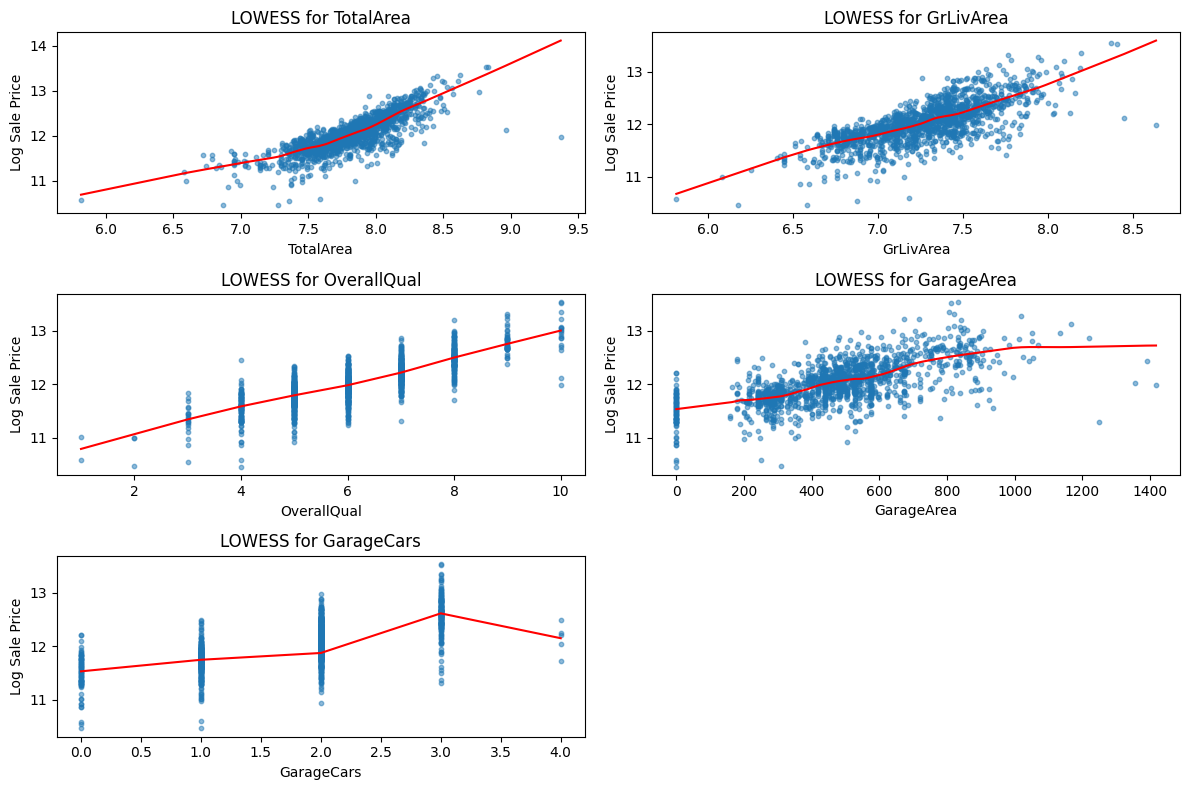

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from google.colab import files


features_to_explore = ['TotalArea', 'GrLivArea', 'OverallQual', 'GarageArea', 'GarageCars']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(features_to_explore, 1):
    lowess = sm.nonparametric.lowess(train_data['SalePrice'], train_data[feature], frac=0.3)
    plt.subplot(3, 2, i)
    plt.scatter(train_data[feature], train_data['SalePrice'], alpha=0.5, s=10)
    plt.plot(lowess[:, 0], lowess[:, 1], color='red')
    plt.title(f"LOWESS for {feature}")
    plt.xlabel(feature)
    plt.ylabel("Log Sale Price")

plt.tight_layout()

plt.savefig("lowess_plots.png")

files.download("lowess_plots.png")


In [ ]:
# Convert categorical variables to dummy variables
train_data = pd.get_dummies(train_data)
test_data = pd.get_dummies(test_data)
final_features = list(set(train_data.columns).intersection(test_data.columns))

#3.Variables Transformation and Scaling





In [ ]:
#Select the top 10 correalted variables
print(saleprice_corr_sorted.head(10).round(4))
top_correlated_features = ['TotalArea', 'GrLivArea', 'OverallQual','YearBuilt','1stFlrSF','FullBath','GarageArea','GarageCars','YearRemodAdd','YearRemodAdd']

OverallQual     0.8172
TotalArea       0.8071
GrLivArea       0.7303
GarageCars      0.6806
GarageArea      0.6509
1stFlrSF        0.6090
FullBath        0.5948
YearBuilt       0.5866
YearRemodAdd    0.5656
TotRmsAbvGrd    0.5344
Name: SalePrice, dtype: float64


In [ ]:
# Create interaction terms for these features
top_features_interaction_terms = list(combinations(top_correlated_features, 2))
for term in top_features_interaction_terms:
    train_data[f'{term[0]}_{term[1]}'] = train_data[term[0]] * train_data[term[1]]
    test_data[f'{term[0]}_{term[1]}'] = test_data[term[0]] * test_data[term[1]]

In [ ]:
# Update the final feature list
final_features = list(set(train_data.columns).intersection(test_data.columns))

# Redefine training and testing data
X = train_data[final_features]
test_X = test_data[final_features]
y= train_data['SalePrice']

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
test_X = scaler.fit_transform(test_X)

In [ ]:
X = pd.DataFrame(data = X, columns = final_features)
test_X = pd.DataFrame(data = test_X, columns = final_features)

# 4.Regularization

##4.1 Elastice Net

In [ ]:
# Determining the best parameters for ElasticNet
alphas = np.logspace(-5, 0, 100)
l1_ratios = np.arange(0.3, 1.0, 0.3)
elastic_net = ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=3, max_iter=500)
elastic_net.fit(X, y)
best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.015612925483591056, tolerance: 0.015371901645461726
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.027358060239379256, tolerance: 0.015371901645461726
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03212618012795154, tolerance: 0.015371901645461726
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:61

In [ ]:
# Training the ElasticNet model with the best parameters and interaction terms
elastic_net_model_interaction = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=1000)
elastic_net_model_interaction.fit(X, y)


ElasticNet(alpha=0.013530477745798061, l1_ratio=0.3)

In [ ]:
# Predicting the test set with the interaction terms model
elastic_net_predictions = elastic_net_model_interaction.predict(test_X)

# Converting the log-transformed predictions back to the original scale
elastic_net_predictions = np.expm1(elastic_net_predictions)
print(elastic_net_predictions[:5])

[120010.69203939 155103.50117409 183629.5123601  198789.79918236
 205722.73071105]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


##4.2 Lasso

In [ ]:
lasso_cv_model = LassoCV(alphas=np.logspace(-5, 0, num=200), cv=5)
# Fit the LassoCV model to the scaled training data
lasso_cv_model.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.019355622768488345, tolerance: 0.01891259276039609
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02211180454494155, tolerance: 0.01891259276039609
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.031418864622448694, tolerance: 0.01891259276039609
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: 

LassoCV(alphas=array([1.00000000e-05, 1.05956018e-05, 1.12266777e-05, 1.18953407e-05,
       1.26038293e-05, 1.33545156e-05, 1.41499130e-05, 1.49926843e-05,
       1.58856513e-05, 1.68318035e-05, 1.78343088e-05, 1.88965234e-05,
       2.00220037e-05, 2.12145178e-05, 2.24780583e-05, 2.38168555e-05,
       2.52353917e-05, 2.67384162e-05, 2.83309610e-05, 3.00183581e-05,
       3.18062569e-05, 3.37006433e-0...
       2.64308149e-01, 2.80050389e-01, 2.96730241e-01, 3.14403547e-01,
       3.33129479e-01, 3.52970730e-01, 3.73993730e-01, 3.96268864e-01,
       4.19870708e-01, 4.44878283e-01, 4.71375313e-01, 4.99450512e-01,
       5.29197874e-01, 5.60716994e-01, 5.94113398e-01, 6.29498899e-01,
       6.66991966e-01, 7.06718127e-01, 7.48810386e-01, 7.93409667e-01,
       8.40665289e-01, 8.90735464e-01, 9.43787828e-01, 1.00000000e+00]),
        cv=5)

In [ ]:
# The optimal alpha selected by lasso cross-validation
optimal_alpha = lasso_cv_model.alpha_
print("Optimal Alpha:", optimal_alpha)

Optimal Alpha: 0.003872038781812557


In [ ]:
lasso_model = Lasso(alpha=optimal_alpha)
lasso_model.fit(X, y)
lasso_predictions = lasso_model.predict(test_X)
lasso_predictions = np.expm1(lasso_predictions)
lasso_predictions

array([119949.1425769 , 155109.95732292, 184087.83652249, ...,
       165239.55954368, 124657.09678469, 237231.11552321])

In [ ]:
lasso_coefficients = lasso_model.coef_
feature_names = final_features
elastic_net_model_coefficients = elastic_net_model_interaction.coef_

lasso_coeff_df =  pd.DataFrame({'Feature': feature_names, 'Lasso Coefficient': lasso_coefficients})
elastic_net_model_coeff_df = pd.DataFrame({'Feature': feature_names, 'Elastic Net Coefficient': elastic_net_model_coefficients})


# Combine the DataFrames
combined_coeff_df = pd.merge(lasso_coeff_df, elastic_net_model_coeff_df)



In [ ]:
# Create an interactive scatter plot using Plotly
fig = px.scatter(combined_coeff_df, x='Feature', y=['Lasso Coefficient','Elastic Net Coefficient'],
                 title='Lasso VS Elastic Net Coefficients', labels={'value': 'Coefficient'})

# Customize layout
fig.update_layout(xaxis={'tickangle': -45, 'title': 'Feature'},
                  yaxis={'title': 'Coefficient'})
fig.update_yaxes(range=[-0.1, 0.1])  # Adjust the range as needed

# Show the interactive plot
fig.show()

In [ ]:
y_pred_elastic = elastic_net_model_interaction.predict(X)
mse_elastic = mean_squared_error(y, y_pred_elastic)
formatted_mse_elastic = "{:.10f}".format(mse_elastic)
print("Formatted MSE Elastic Net:", formatted_mse_elastic)


y_pred_lasso = lasso_model.predict(X)
mse_lasso = mean_squared_error(y, y_pred_lasso)
formatted_mse_lasso = "{:.10f}".format(mse_lasso)
print("Formatted MSE in Lasso:", formatted_mse_lasso)

Formatted MSE Elastic Net: 0.0116638063
Formatted MSE in Lasso: 0.0115491969


#5.Ensemble Prediction

In [ ]:
from sklearn.metrics import mean_squared_error

def blend_models(X):
    return ((y_pred_elastic) + (y_pred_lasso))/2
blended_score = (mean_squared_error(y, blend_models(X)))
blended_score
print("Formatted MSE in Ensemble Model:", blended_score)

Formatted MSE in Ensemble Model: 0.011604472448605505


In [ ]:
from IPython.display import display, HTML

data = {
    'Ensemble Model': round(blended_score, 6),
    'Lasso': round(mse_lasso, 6),
    'Elastic Net': round(mse_elastic, 6)
}
sorted_data = sorted(data.items(), key=lambda x: x[1])
sorted_data_dict = {model: mse for model, mse in sorted_data}
df = pd.DataFrame([sorted_data_dict], index=['MSE'])

from google.colab import drive

drive.mount('/content/drive')
df.to_csv('/content/drive/MyDrive/mse_results.csv',index = False)
display(HTML(df.to_html(index=False)))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lasso,Ensemble Model,Elastic Net
0.011549,0.011604,0.011664


In [ ]:
def blend_models(test_X):
    return ((elastic_net_predictions)+(lasso_predictions))/2
blend_models(test_X)

array([119973.57778477, 155057.34901992, 183839.22244804, ...,
       165104.24363704, 124839.14440428, 236899.8094605 ])

In [ ]:
#Generate the submission file
from google.colab import drive
drive.mount('/content/drive')
sample_submission_df = pd.read_csv('https://www.dropbox.com/scl/fi/fxiwfe47v7odz6qdukl0h/sample_submission.csv?rlkey=v8eknwjn58j9t0v9wu856yx6c&dl=1')
sample_submission_df['SalePrice'] = blend_models(test_X)
sample_submission_df.to_csv('/content/drive/MyDrive/Assignment 4.csv', index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
